In [1]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import astropy
from matplotlib.pyplot import cm
from astropy import constants as const
from astropy import units as u
import numpy.ma as ma
from scipy.stats import mode
from scipy.misc import imread
import imageio
from lmfit.models import LinearModel, LorentzianModel
import matplotlib.patches as patches
from matplotlib.patches import Circle
from skimage import img_as_float, measure, feature
from skimage.transform import rotate as skrotate
from photutils.centroids import centroid_com
from itertools import combinations
import os
import time
import scipy
import cv2
import solar_features as sol
from scipy.optimize import curve_fit


In [2]:
#test = sol.sun_img('20120928004014Mh.jpg') #first one: mean_inten: 120

#test = sol.sun_img('20111114175814Mh.jpg') #mean_inten: 124
#test = sol.sun_img('20111114232414Mh.jpg')  #mean_inten: 124
#test = sol.sun_img('20111114175814Mh.jpg') #mean_inten: 124 - 125

#test = sol.sun_img('20111128001114Mh.jpg') #mean_inten: 125

#test = sol.sun_img('20120109000014Mh.jpg')
test = sol.sun_img('20120109001014Mh.jpg')
#test = sol.sun_img('20120109002014Mh.jpg')
#test = sol.sun_img('20120109003014Mh.jpg')
#test = sol.sun_img('20120109004014Mh.jpg')
#test = sol.sun_img('20120109005014Mh.jpg')
#test = sol.sun_img('20120109010014Mh.jpg')
#test = sol.sun_img('20120109011014Mh.jpg')
#test = sol.sun_img('20120109020014Mh.jpg')
#test = sol.sun_img('20120109030014Mh.jpg')

#test = sol.sun_img('')


In [45]:
a, b = sol.sun_img.separate_images(test)

r = sol.sun_img.circle_properties(test)[0][2]
x = sol.sun_img.circle_properties(test)[0][0]
y = sol.sun_img.circle_properties(test)[0][1]

center = (x,y)

print(center)
print(r)

(151, 153)
134


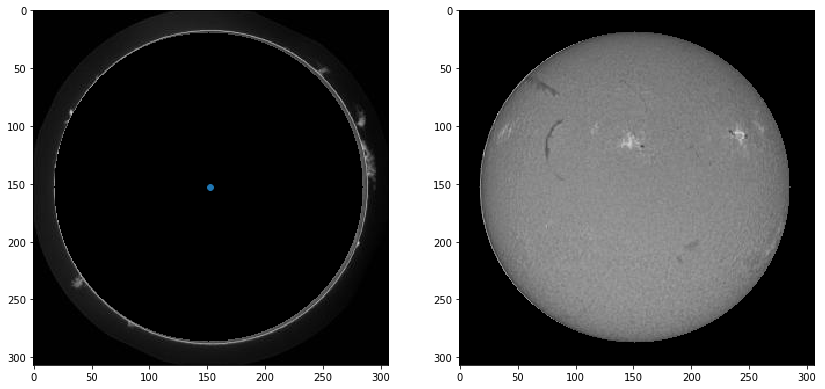

In [48]:
fig1 = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(a)
plt.scatter(x+1,y)


plt.subplot(1, 2, 2)
plt.imshow(b)

plt.show()

In [5]:
## Add circles to test transformation
#cv2.circle(a,(x+r,y), 5, (0,0,255), -1)
#cv2.circle(a,(x-r,y), 5, (0,0,255), -1)
#cv2.circle(a,(x,y+r), 5, (0,0,255), -1)
# cv2.circle(a,(x,y-r), 5, (0,0,255), -1)

In [6]:
flat = cv2.linearPolar(a, center,r+50,cv2.WARP_FILL_OUTLIERS)
recover = cv2.linearPolar(flat, center,r+50,cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP)
print(np.shape(a))

(307, 307, 3)


## Make it so it starts cutting where there is nothing?

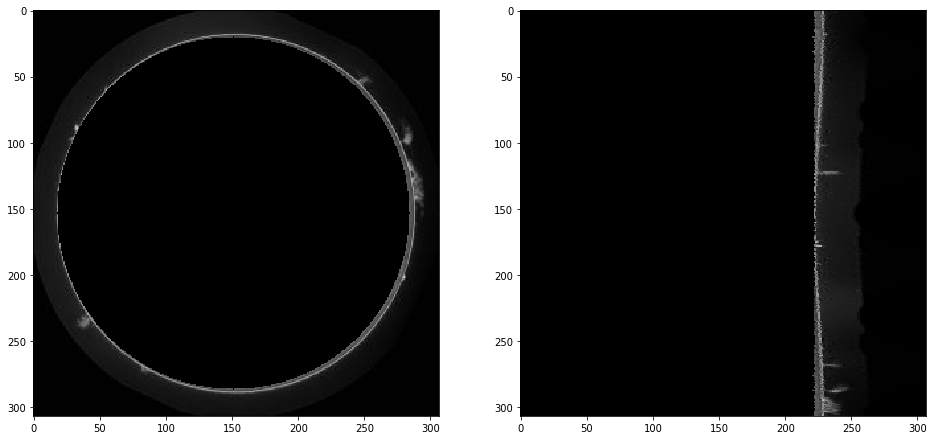

In [7]:
fig2 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(a)


plt.subplot(1, 2, 2)
plt.imshow(flat)


plt.show()

In [8]:
flat_g = cv2.cvtColor(flat, cv2.COLOR_BGR2GRAY)
rows,cols = flat_g.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv2.warpAffine(flat_g,M,(cols,rows))

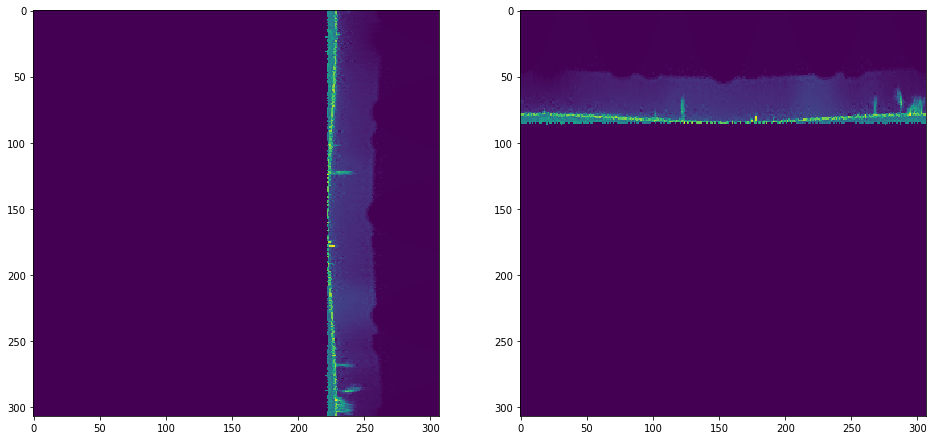

In [9]:
fig3 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(flat_g)


plt.subplot(1, 2, 2)
plt.imshow(dst)


plt.show()

In [10]:
zoom = dst[40:100,:]



In [11]:
mean_int=np.mean(zoom[np.nonzero(zoom)])
median_int=np.median(zoom[np.nonzero(zoom)])
print(mean_int)
print(median_int)

29.338159664530423
21.0


In [12]:
ret,thresh4 = cv2.threshold(zoom,1.35*mean_int,0,cv2.THRESH_TOZERO)
ret5,thresh5 = cv2.threshold(dst,1.35*mean_int,0,cv2.THRESH_TOZERO)

#blur = cv2.GaussianBlur(cropped, (1,1),0)
#blur = cv2.bilateralFilter(cropped,5,33,33)


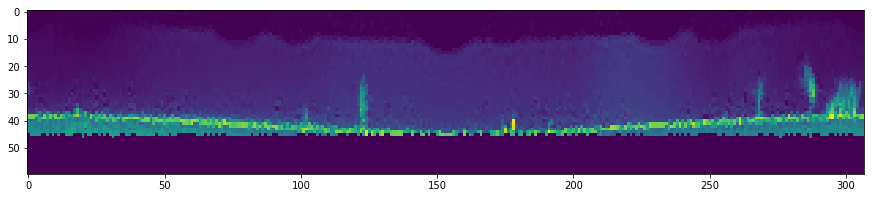

In [13]:
fig4 = plt.figure(figsize=(15,60))

plt.imshow(zoom)


plt.show()

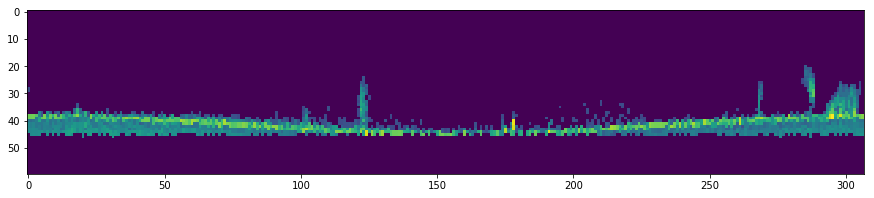

In [14]:

fig5 = plt.figure(figsize=(15,30))

plt.imshow(thresh4)


plt.show()

(60, 307)
(307,)


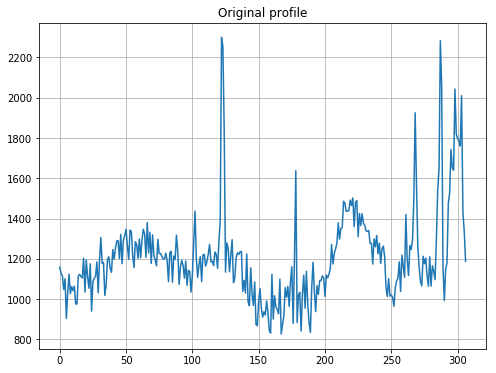

In [15]:
cropped_1D = np.sum(zoom, axis=0)
print(zoom.shape)
print(cropped_1D.shape)
fig7 = plt.figure(figsize=(8,6))

plt.plot(np.arange(np.shape(zoom)[1]), cropped_1D)
plt.grid()
plt.title('Original profile')
plt.show()

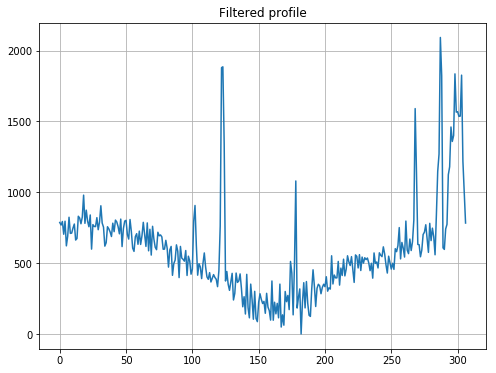

In [16]:
#filtered_1D = np.sum(thresh4, axis=0)
filtered_1D = np.sum(thresh5, axis=0)


fig8 = plt.figure(figsize=(8,6))
plt.plot(np.arange(np.shape(dst)[1]), filtered_1D)
plt.grid()
plt.title('Filtered profile')

plt.show()

In [17]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int((window_len/2-1)):-int(window_len/2)]



In [18]:
smoothed_1D = smooth(filtered_1D,window_len=11, window='hanning')
sm_len = len(smoothed_1D)
x = np.arange(sm_len)

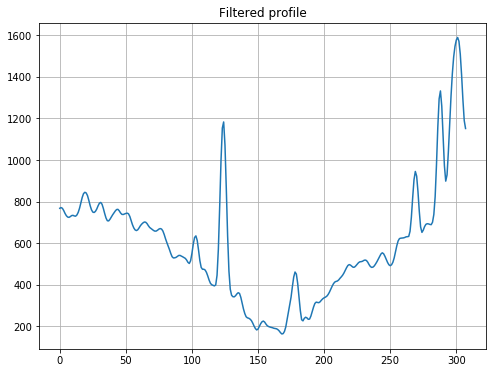

In [19]:
fig9 = plt.figure(figsize=(8,6))
plt.plot(x, smoothed_1D)

plt.grid()
plt.title('Filtered profile')

plt.show()

In [20]:
sm_max = np.max(smoothed_1D)
sm_argmax = np.argmax(smoothed_1D)
sm_std = np.std(smoothed_1D)

sm_min =np.r_[True, smoothed_1D[1:] < smoothed_1D[:-1]] & np.r_[smoothed_1D[:-1] < smoothed_1D[1:], True]
sm_argmin = np.where(sm_min==True)
sm_argmin = np.asarray(sm_argmin[0])
sm_argmin= np.append(sm_argmin, x[-1])

new_curve = smoothed_1D.copy()
parameters = list()
ranges = list()
covariances = list()
peak_ind = list()


In [21]:
while sm_max > 2*sm_std:
    if (sm_argmax != sm_len -1) & (sm_argmax > sm_argmin[0]):
        min1 = sm_argmin[np.where((sm_argmin<sm_argmax))[0]][-1]
        min2 = sm_argmin[np.where((sm_argmin>sm_argmax))[0]][0]
        x_range =x[min1:min2]
        y_range = smoothed_1D[min1:min2]
        amp = sm_max
        mean = sm_argmax
        sigma = np.std(y_range)
        lore_mod = LorentzianModel(prefix='lore_')
        line_mod = LinearModel(prefix='line_')

        #p=[amp,mean,3*sigma]
        if len(x_range)>5:
            #popt,pcov = curve_fit(gaus,x_range,y_range,p0=[amp,mean,sigma])
            #popt,pcov = curve_fit(lorentzian,x_range,y_range,p)
            pars = line_mod.make_params(intercept=y_range.min(), slope=0)

            pars += lore_mod.guess(y_range, x=x_range)
           

            mod = lore_mod + line_mod
            out = mod.fit(y_range, pars, x=x_range)
            ranges.append(np.asarray((min1,min2)))
            #perr = np.sqrt(np.diag(pcov))

            parameters.append(out)              
            #covariances.append(perr)
            peak = np.zeros(sm_len)
            #peak[min1:min2]=lorentzian(x[min1:min2],*popt )
            #peak[min1:min2]=gaus(x[min1:min2],*popt )
            peak[min1:min2]=out.best_fit
            peak_ind.append(sm_argmax)

            new_curve = new_curve - peak
            sm_max = np.max(new_curve)
            sm_argmax = np.argmax(new_curve)
        else: 
            new_curve[sm_argmax]=0
            sm_max = np.max(new_curve)
            sm_argmax = np.argmax(new_curve)
    else:
        new_curve[sm_argmax]=0
        sm_max = np.max(new_curve)
        sm_argmax = np.argmax(new_curve)

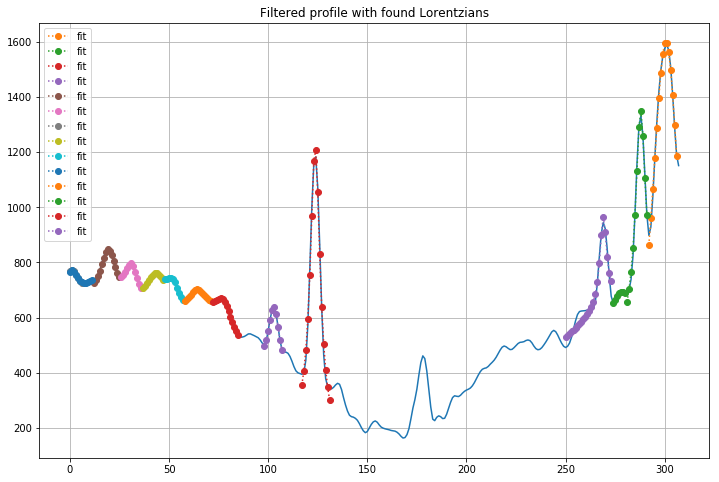

In [22]:
fig10 = plt.figure(figsize=(12,8))
plt.plot(x, smoothed_1D)
for i in range(len(parameters)):
    #plt.plot(x[ranges[i][0]:ranges[i][1]],gaus(x[ranges[i][0]:ranges[i][1]],*parameters[i]),'o:',label=covariances[i])
    #plt.plot(x[ranges[i][0]:ranges[i][1]],lorentzian(x[ranges[i][0]:ranges[i][1]],*parameters[i]),'o:',label='fit')
    plt.plot(x[ranges[i][0]:ranges[i][1]],parameters[i].best_fit,'o:',label='fit')

plt.grid()
plt.title('Filtered profile with found Lorentzians')
plt.legend()
plt.show()

In [23]:
centers = np.asarray([i.best_values['lore_center'] for i in parameters])
amplitudes = np.asarray([i.best_values['lore_amplitude'] for i in parameters])
sigmas = np.asarray([i.best_values['lore_sigma'] for i in parameters])
h = np.asarray([np.max(parameters[i].best_fit)-np.min(parameters[i].best_fit) for i in range(len(parameters))])
norm_h = h/np.max(h)

In [24]:
norm_smoothed = smoothed_1D/np.max(smoothed_1D)

In [25]:
ind = np.where(norm_h>0.1)

In [26]:
some_parameters = np.asarray(parameters)[ind[0]]
some_ranges = np.asarray(ranges)[ind[0]]
some_intensities = np.asarray(smoothed_1D[np.asarray(peak_ind)[ind]])
norm_fits = np.asarray([some_parameters[i].best_fit/np.max(smoothed_1D) for i in range(len(some_parameters))])

In [27]:
np.shape(some_ranges)

(7, 2)

In [28]:
some_centers = np.asarray(centers[np.where(norm_h> 0.1)[0]])
some_centers = np.asarray([int(i) for i in some_centers])
some_amplitudes = np.asarray(amplitudes[np.where(norm_h>0.1)[0]])
some_sigmas = np.asarray(sigmas[np.where(norm_h>0.1)[0]])
some_normh = np.asarray(norm_h[np.where(norm_h>0.1)[0]])



In [29]:
some_centers[np.where(some_centers<0)]=0
some_centers[np.where(some_centers>len(x)-1)]=len(x)-1

In [30]:
sort = np.sort(some_centers)
sort_ind = np.argsort(some_centers)
repeated_peaks = list()
for i in np.arange(len(some_centers)-1):
    step = sort[i+1]-sort[i]
    if step <= 3:
        repeated_peaks.append(sort_ind[i])

In [31]:
some_parameters = np.delete(some_parameters, repeated_peaks)
some_ranges = np.delete(some_ranges, repeated_peaks,0)
some_intensities = np.delete(some_intensities, repeated_peaks)
norm_fits = np.delete(norm_fits, repeated_peaks)
some_centers = np.delete(some_centers, repeated_peaks)
some_amplitudes = np.delete(some_amplitudes, repeated_peaks)
some_sigmas = np.delete(some_sigmas, repeated_peaks)
some_normh = np.delete(some_normh, repeated_peaks)

In [32]:
sort

array([ 19,  77, 102, 123, 268, 287, 300])

In [33]:
rows1,cols1 = dst.shape

M1 = cv2.getRotationMatrix2D((cols1/2,rows1/2),-90,1)
rot = cv2.warpAffine(dst,M1,(cols1,rows1))

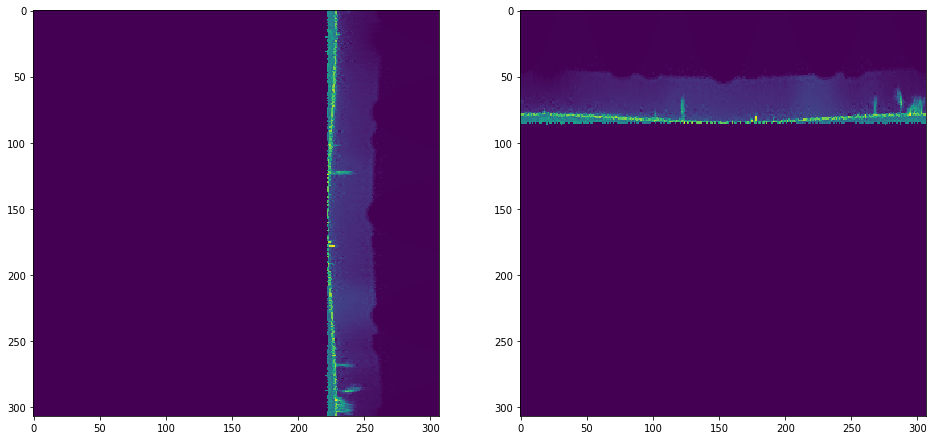

In [34]:
fig30 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(rot)


plt.subplot(1, 2, 2)
plt.imshow(dst)


plt.show()

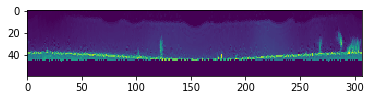

In [35]:
plt.imshow(zoom)

In [36]:
L = np.shape(rot)[0]
cord = some_centers.copy()-1
cord_phi = [(2*np.pi*cord[i])/L for i in np.arange(len(cord))]
cord_r = (r-10)


In [37]:
cord_x = [(cord_r*np.cos(i))+L/2 for i in cord_phi]
cord_y = [(cord_r*np.sin(i))+L/2 for i in cord_phi]

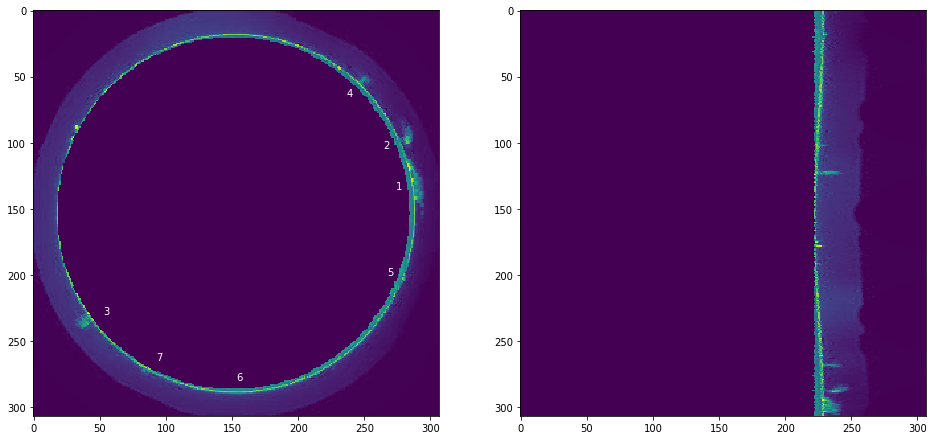

In [38]:
recover1 = cv2.linearPolar(rot, center,r+50,cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP)


fig20 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(recover1)
#plt.scatter(cord_x,cord_y)
for i in np.arange(len(cord_x)):
    plt.text(cord_x[i]-2, cord_y[i]+2,str(i+1), color='white')

plt.subplot(1, 2, 2)
plt.imshow(rot)


plt.show()

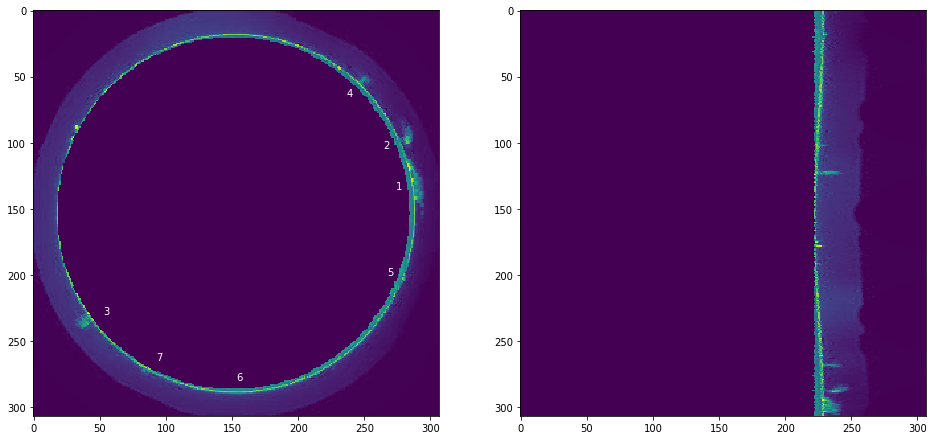

In [39]:
from matplotlib import gridspec

fig21 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(recover1)
#plt.scatter(cord_x,cord_y)
for i in np.arange(len(cord_x)):
    plt.text(cord_x[i]-2, cord_y[i]+2,str(i+1), color='white')

plt.subplot(1, 2, 2)
plt.imshow(rot)


plt.show()

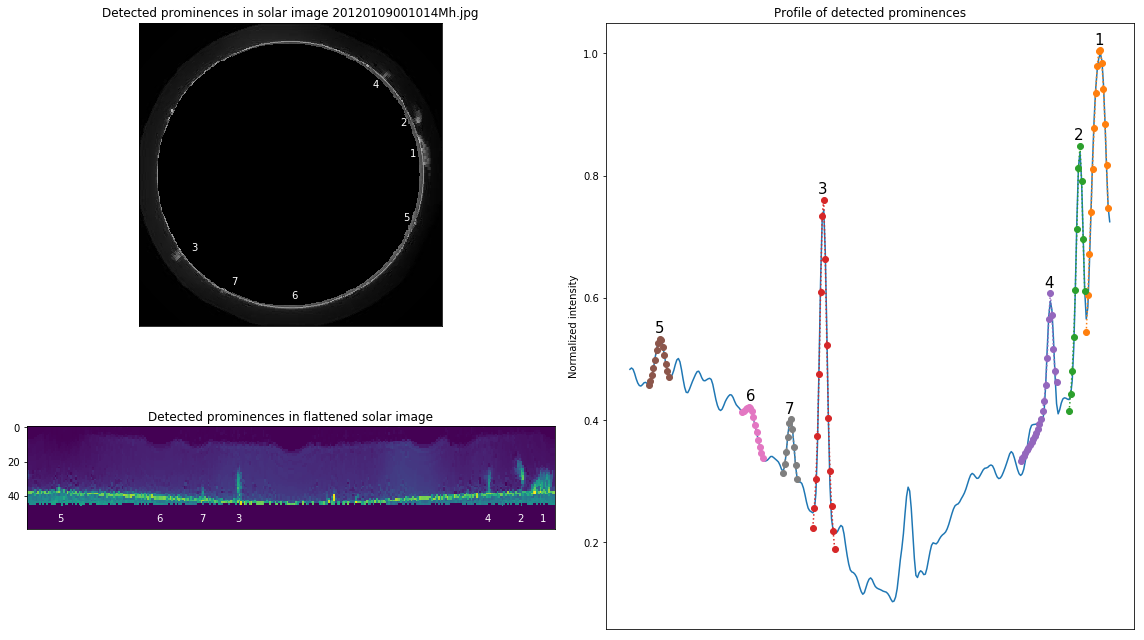

In [40]:
fig = plt.figure(figsize=(16, 9))
ax0 = plt.subplot2grid((2,2), (0, 0), rowspan=1)
ax0.imshow(recover)
for i in np.arange(len(cord_x)):
    plt.text(cord_x[i]-2, cord_y[i]+2,str(i+1), color='white')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Detected prominences in solar image ' +test.path)

ax1 = plt.subplot2grid((2,2), (1, 0))
ax1.imshow(zoom)
for i in np.arange(len(some_centers)):
    plt.text(some_centers[i]-2, 55,str(i+1), color='white')
ax1.set_xticks([])
ax1.set_yticks
ax1.set_title('Detected prominences in flattened solar image')

ax2 = plt.subplot2grid((2,2), (0, 1),rowspan=2)
ax2.plot(x, norm_smoothed)
for i in range(len(some_parameters)):
    ax2.plot(x[some_ranges[i][0]:some_ranges[i][1]],norm_fits[i],'o:',label='fit')
    ax2.text(some_centers[i]-3, np.max(norm_fits[i])+0.01,str(i+1), color='black', size=15)
ax2.set_xticks([])
ax2.set_title('Profile of detected prominences')
ax2.set_ylabel('Normalized intensity')


#plt.subplots_adjust(wspace=0.2, hspace=0)
plt.tight_layout(pad=1.1,h_pad=0.1)


In [41]:
results = np.empty((len(some_parameters)+1,6), dtype=object)
for i in np.arange(len(some_parameters)):
    # Table header
    results[0,:]= ['Name', 'Flat Position.', 'Radial Position', 'Height of the peak over the noise', 'Width', 'Intensity of the peak']
    # Name of the prominence: 1, 2, 3, 4...
    results[i+1,0]=str(i+1)
    
    # Coordinates of the prominence in flat projection
    results[i+1,1]= int(some_centers[i])
    
    # Coordinates of the prominence in circular projection: 
    results[i+1,2] = (cord_x[i], cord_y[i])
    
    # Height of the peak over the noise
    results[i+1,3] = some_amplitudes[i]
    
    # Width of the peak
    results[i+1,4] = some_sigmas[i]
    # Intensity of the peak 
    results[i+1,5] = some_intensities[i]


In [42]:
results

array([['Name', 'Flat Position.', 'Radial Position',
        'Height of the peak over the noise', 'Width',
        'Intensity of the peak'],
       ['1', 300, (275.84161934991624, 133.28792007634536),
        48642.87199014134, 9.413848934533481, 1588.9041386231213],
       ['2', 287, (266.22237665580747, 101.83119121688335),
        7362.367160489486, 3.047080108288501, 1331.9143892119887],
       ['3', 123, (54.3886466992967, 228.01804913511336),
        10070.90559809539, 3.0324088328825898, 1182.7803312339854],
       ['4', 268, (238.21719711888977, 62.95168962195275),
        2110.199234789653, 2.070165782005088, 944.8432442550583],
       ['5', 19, (269.1804003634039, 198.15473067618447),
        2469.5697024538113, 4.658267320948144, 844.6995934690619],
       ['6', 77, (155.40330061011377, 277.4853920701448),
        1718.3554248793937, 5.384953581761373, 670.3174721768112],
       ['7', 102, (94.45315753245468, 262.5388480983401),
        2578.015116631635, 3.4465547985171625,

In [43]:
test.path[:14]

'20120109001014'